In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Reshape, Bidirectional, LSTM, Flatten
from tensorflow.keras import regularizers
from IPython.display import Image
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling

In [ ]:
! unzip /content/drive/MyDrive/Combined_Dataset.zip
dataset_dir = "/content/content/AIRecognition"

Streaming output truncated to the last 5000 lines.
  inflating: content/AIRecognition/fake/fake-v2/13943.png  
  inflating: content/AIRecognition/fake/fake-v2/2587.jpg  
  inflating: content/AIRecognition/fake/fake-v2/11963.jpg  
  inflating: content/AIRecognition/fake/fake-v2/20878.png  
  inflating: content/AIRecognition/fake/fake-v2/13839.png  
  inflating: content/AIRecognition/fake/fake-v2/19956.png  
  inflating: content/AIRecognition/fake/fake-v2/22093.png  
  inflating: content/AIRecognition/fake/fake-v2/2704.jpg  
  inflating: content/AIRecognition/fake/fake-v2/16898.png  
  inflating: content/AIRecognition/fake/fake-v2/20703.png  
  inflating: content/AIRecognition/fake/fake-v2/23931.png  
  inflating: content/AIRecognition/fake/fake-v2/17039.png  
  inflating: content/AIRecognition/fake/fake-v2/2647.jpg  
  inflating: content/AIRecognition/fake/fake-v2/24691.png  
  inflating: content/AIRecognition/fake/fake-v2/19245.png  
  inflating: content/AIRecognition/fake/fake-v2/1372

In [ ]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2),  # Randomly adjust contrast
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


In [ ]:
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3)
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
EfficientNet_model.summary()

24274472/24274472 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5920593 (22.59 MB)
Trainable params: 5859985 (22.35 MB)
Non-trainable params: 60608 (236.75 KB)
________________

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

EfficientNet_model_history = EfficientNet_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
EfficientNet_model.save('EfficientNet_LSTM')

Epoch 1/100
221/221 [==============================] - 398s 2s/step - loss: 0.2759 - accuracy: 0.8833 - precision: 0.8602 - recall: 0.7983 - val_loss: 0.1786 - val_accuracy: 0.9239 - val_precision: 0.9781 - val_recall: 0.8030
Epoch 2/100
221/221 [==============================] - 345s 2s/step - loss: 0.1871 - accuracy: 0.9265 - precision: 0.9131 - recall: 0.8746 - val_loss: 0.1522 - val_accuracy: 0.9468 - val_precision: 0.9500 - val_recall: 0.8969
Epoch 3/100
221/221 [==============================] - 346s 2s/step - loss: 0.1507 - accuracy: 0.9426 - precision: 0.9307 - recall: 0.9041 - val_loss: 0.1869 - val_accuracy: 0.9365 - val_precision: 0.9790 - val_recall: 0.8384
Epoch 4/100
221/221 [==============================] - 335s 1s/step - loss: 0.1414 - accuracy: 0.9473 - precision: 0.9367 - recall: 0.9118 - val_loss: 0.1453 - val_accuracy: 0.9465 - val_precision: 0.9742 - val_recall: 0.8717
Epoch 5/100
221/221 [==============================] - 343s 2s/step - loss: 0.1266 - accuracy: 0

In [ ]:
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 35s 538ms/step - loss: 0.1211 - accuracy: 0.9590 - precision: 0.9595 - recall: 0.9230
Val Loss: 0.1211
Val Accuracy: 0.9512
Val Precision: 0.9495
Val Recall: 0.9130


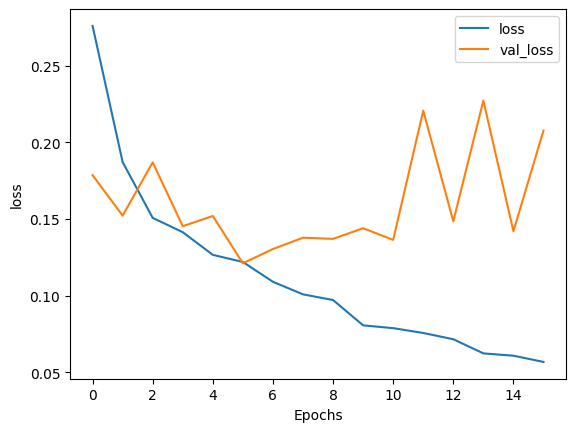

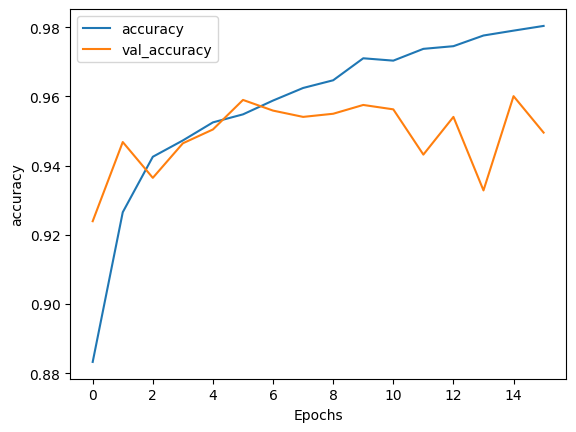

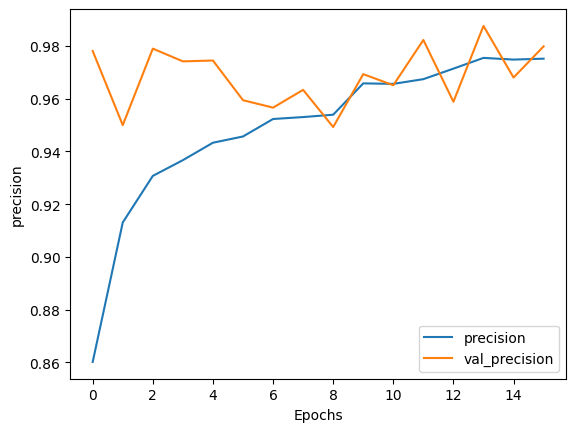

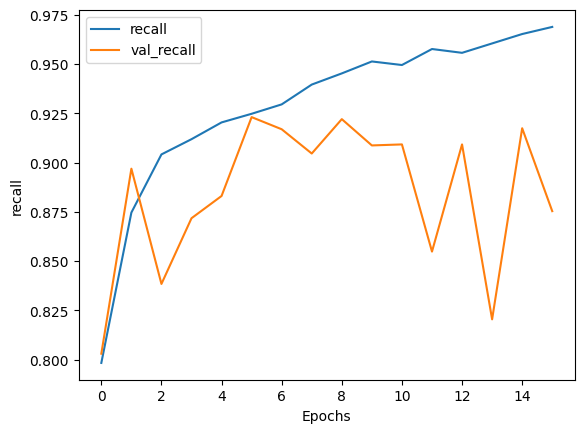

In [ ]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision')
plot_metrics(EfficientNet_model_history, 'recall')